In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr,ttest_ind
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from sklearn.svm import LinearSVC,SVC
from sklearn.preprocessing import StandardScaler,FunctionTransformer
from sklearn.metrics import RocCurveDisplay,classification_report
from sklearn.model_selection import (train_test_split,cross_validate,
    GridSearchCV,StratifiedKFold)
from sklearn.feature_selection import RFECV,SelectFromModel
from sklearn.pipeline import Pipeline

import shap
from statsmodels.stats.multitest import multipletests

from collections import Counter
import ipyparallel as ipp
from contextlib import redirect_stderr
import os
from tqdm.notebook import trange,tqdm
import joblib
import yaml

In [2]:
%matplotlib inline
%load_ext watermark

In [3]:
# set a fixed random state for reproduceability random state from random.org
import random
random.seed(0x9e3047133e3412828a6be28778850f1d32b61c929e6859fae158ec6bce96c044b1bea5d0c60740f4800863a87a4f6775)
np.random.seed(random.randint(0, 0x1<<31))

collinear_gridsearch_rand_seed = random.getrandbits(30)
rfecv_rand_seed = random.getrandbits(30)
classification_report_rand_seed = random.getrandbits(30)
permutation_test_rand_seed = random.getrandbits(30)
shap_bootstrap_rand_seed = random.getrandbits(30)

In [4]:
with open('../data/gene-names.yaml') as in_fd:
    name_map = yaml.load(in_fd, yaml.FullLoader)
    
data = pd.read_csv('../data/grouped-cancer-dataset.csv.xz')
data.rename(
    inplace=True,
    columns={
        k : name_map.get(k, k)
            for k in data.columns
    }
)
data.head()

,Hugo_Symbol,Label,VPS13A-AS1,UBE2Q2P2,UBE2Q2P3.1,HMGB1P1,TIMM23,MOXD2P,LOC155060,RNU12-2P,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,TPTEP1,AKR1C6P
0,BA-A1-A0SO,E,0.0,12.5687,21.4958,383.9288,669.9357,0,143.0169,1.0814,...,71.6436,561.2536,374.1691,108.4117,1791.9022,1341.2231,821.0632,897.8436,444.4610,0.0
1,BA-A2-A04Q,E,0.0,1.1801,3.8334,185.5958,1706.1319,0,354.8014,0.3857,...,37.0228,298.4960,885.4609,127.2657,728.4998,4357.1153,896.6448,568.0679,26.2245,0.0
2,BA-A2-A04T,E,0.0,16.6878,23.9972,232.6558,758.0631,0,165.8698,0.3477,...,88.6725,739.2854,1018.8646,155.7854,1028.6012,3453.7077,1616.2740,655.1334,401.9821,0.0
3,BA-A2-A04U,E,0.0,0.0000,0.5195,411.4041,4388.1024,0,78.9713,0.0000,...,17.6646,174.0486,875.4384,130.4065,589.1674,3222.7562,617.7426,1264.0603,85.7254,0.0
4,BA-A2-A0D2,E,0.0,9.8281,9.3920,177.6492,1826.2798,0,164.8494,0.0000,...,41.0275,402.1438,906.6716,185.5480,1189.7986,10575.1247,743.6703,928.1094,20.3290,0.0


drop genes that were found to be duplicate or discontinued by searching Entrez.

In [5]:
to_drop = [l for l in data.columns if l.endswith('-alt') or l.endswith('-discontinued')]
data.drop(inplace=True, columns=to_drop)
print('dropped', len(to_drop), 'for being duplicate or removed by ncbi')
del to_drop

dropped 142 for being duplicate or removed by ncbi


Search the data for constant columns and drop them since they contain no information.

In [6]:
constant_columns = data.columns[(data.nunique() == 1)]
data.drop(columns=constant_columns, inplace=True)
print('dropped', len(constant_columns), 'columns for being constant')

dropped 470 columns for being constant


Find columns that have most of the data represented by a single value. When these columns are used in 5-fold cross there will very likely be a single value in some of the folds. This is mostly a problem with the permutation test. The correlations of the raw data keep these columns from being selected by LIBLINEAR. Once the relationship is destroyed by the permutation they can float to the surface and cause the spearmanr code to error.

In [7]:
sparse_columns = [c for c in data.columns[2:] if np.any(data[c].value_counts(normalize=True) > 1/3)]
data.drop(columns=sparse_columns, inplace=True)
print('dropped', len(sparse_columns), 'columns for being sparse')

dropped 2839 columns for being sparse


In [8]:
data.describe()

,UBE2Q2P2,UBE2Q2P3.1,HMGB1P1,TIMM23,LOC155060,EFCAB8,SRP14P1,RSKR,HSPB1P1,TMPRSS11E,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,TPTEP1
count,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,...,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000
mean,10.639727,10.021203,155.767873,1366.055649,205.331805,1.552670,5.034480,12.159196,349.022063,23.780497,...,1071.838561,52.125130,402.859620,1046.847814,155.232602,940.979580,5177.534854,1105.346948,1012.307186,226.644723
std,8.697243,7.858926,78.771835,679.889290,156.563507,2.340175,3.974171,12.170863,811.119724,74.577140,...,653.820139,24.784909,168.060015,286.459651,126.529202,384.799084,2725.627891,450.914278,411.879425,281.428133
min,0.000000,0.000000,61.356500,345.121200,34.621600,0.000000,0.343500,0.000000,17.254300,0.000000,...,91.060700,8.808000,86.318300,374.169100,0.587200,340.575500,1168.611800,351.851900,244.862000,1.787200
25%,4.183075,4.431550,102.349100,916.759375,107.842150,0.347250,2.688500,4.781425,91.113475,0.494500,...,668.583525,32.582350,280.131575,849.554700,57.316650,686.346175,3435.013025,803.858975,682.617675,26.109600
50%,9.359550,7.962300,132.494250,1298.277450,164.682750,0.826100,4.207450,9.316200,155.624500,2.587250,...,917.391000,51.245200,385.669450,1025.292150,128.699050,845.120700,4516.313950,1014.324900,976.320850,133.203000
75%,15.122225,12.955500,188.186600,1684.130925,236.366800,1.629625,6.864375,14.769950,305.003275,14.778725,...,1306.365375,65.832225,505.437450,1240.338275,231.031525,1112.490650,6459.738550,1335.991700,1259.015800,296.631650
max,53.997100,40.253600,505.282600,4850.556400,1042.919600,16.273800,36.758300,91.448700,8172.480600,697.240900,...,3752.020900,135.308300,976.134100,1741.395300,590.197400,2449.850900,23934.233700,3300.239100,2839.058500,1467.178800


In [9]:
print(data['Label'].value_counts())

X = data.drop(columns=['Hugo_Symbol', 'Label'])
Y = data['Label']

E    87
A    41
Name: Label, dtype: int64


In [10]:
min_data = pd.pivot_table(data, index=['Label'], aggfunc=np.min)
max_data = pd.pivot_table(data, index=['Label'], aggfunc=np.max)

np.any((min_data.loc['A'] > max_data.loc['E']) | (max_data.loc['A'] < min_data.loc['E']))

False

In [11]:
clf = Pipeline([
    ('standardize',StandardScaler()),
    ('clf', LinearSVC(
        penalty='l1',
        class_weight='balanced',
        dual=False,
        verbose=True,
        max_iter=10000
    ))
])
selector = SelectFromModel(
    clf, 
    importance_getter='named_steps.clf.coef_'
)

selector.fit(X, Y)
l1_feature_names = list(selector.get_feature_names_out())

print('number of features', len(l1_feature_names))
print('Features selected:', *l1_feature_names)

[LibLinear].......................................................*..............................................................*.......................................*.............................................*...................*.............................*.........................*......**..*
optimization finished, #iter = 2822
Objective value = 3.434410
#nonzeros/#features = 94/17081
number of features 91
Features selected: ADAM19 ADH5 AMFR ANKRD20A3P APTX ASB6 ATXN7L3 BTNL8 DHRS4-AS1 PRR34 MIR3667HG PLGRKT CALHM1 CAT CCL4L1 CHURC1 CRHR1 CRISPLD1 CROCCP2 CYP4V2 DDX51 DNASE1L1 EFR3B Fam122c ZNF473CR FOXA3 FOXQ1 GOLGA6L9 GPR179 GPR17 GPR89B HEXIM1 HIP1R HTR1B KCNE3 ELAPOR2 KLK10 KRT40 LIMS3 LINC02610 BHLHE22-AS1 XRCC6P5 SCGB1B2P ASH1L-AS1 KATNBL1P6 POLR1A LRRC37A2 LRRC37A MAP2K7 MRPL42P5 MYO3A A1BG-AS1 NRM NRXN3 PAX6 PCDHA13 PDHX PIF1 PKDREJ PLA2G4C PLP2 POLR2J3 POMZP3 POU5F1 PPIL3 PRKY PRSS30P Prss45 PWP2 RBPJ ROS1 RPP40 RPS26P11 SBDSP1 SERPINC1 Smc1b SRD5A2 SSPOP SULT1E1 SYC

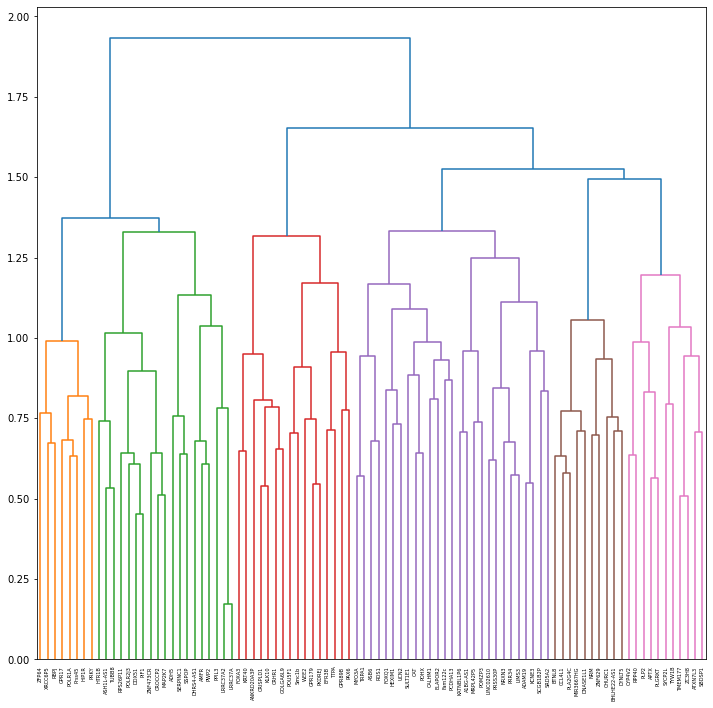

In [12]:
# borrowed directly from scikit learn docs:
# https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#handling-multicollinear-features
corr = spearmanr(X[l1_feature_names]).correlation
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

plt.figure(figsize=(12,12))
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=l1_feature_names, ax=plt.gca(), leaf_rotation=90
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


selected theshold 0.35
number of features selected 91
selected features: ADAM19 ADH5 AMFR ANKRD20A3P APTX ASB6 ATXN7L3 BTNL8 DHRS4-AS1 PRR34 MIR3667HG PLGRKT CALHM1 CAT CCL4L1 CHURC1 CRHR1 CRISPLD1 CROCCP2 CYP4V2 DDX51 DNASE1L1 EFR3B Fam122c ZNF473CR FOXA3 FOXQ1 GOLGA6L9 GPR179 GPR17 GPR89B HEXIM1 HIP1R HTR1B KCNE3 ELAPOR2 KLK10 KRT40 LIMS3 LINC02610 BHLHE22-AS1 XRCC6P5 SCGB1B2P ASH1L-AS1 KATNBL1P6 POLR1A LRRC37A2 LRRC37A MAP2K7 MRPL42P5 MYO3A A1BG-AS1 NRM NRXN3 PAX6 PCDHA13 PDHX PIF1 PKDREJ PLA2G4C PLP2 POLR2J3 POMZP3 POU5F1 PPIL3 PRKY PRSS30P Prss45 PWP2 RBPJ ROS1 RPP40 RPS26P11 SBDSP1 SERPINC1 Smc1b SRD5A2 SSPOP SULT1E1 SYCP2L DYNLT5 TMEM177 TRPA1 TTPA TUBB8 TYW1B UCN2 WEE2 ZC3H8 ZFP64 ZNF629


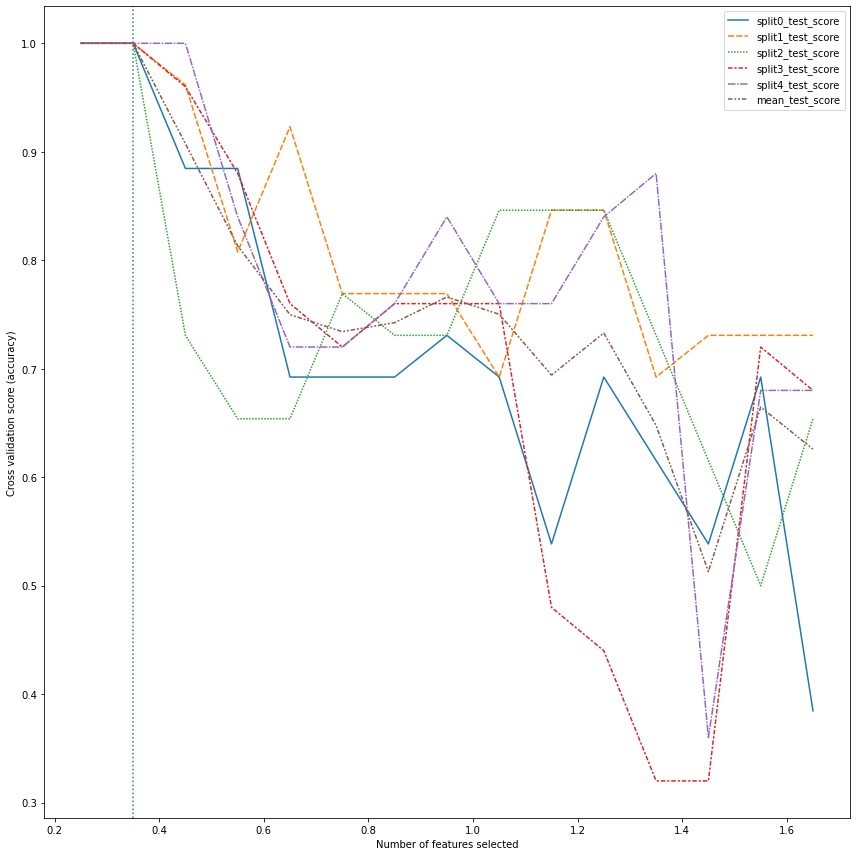

In [13]:
def drop_collinear_features(X, threshold=0):
    # borrowed directly from scikit learn docs:
    # https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#handling-multicollinear-features
    corr = spearmanr(X).correlation
    corr = (corr + corr.T) / 2
    np.fill_diagonal(corr, 1)
    
    distance_matrix = 1 - np.abs(corr)
    dist_linkage = hierarchy.ward(
        squareform(
            np.nan_to_num(distance_matrix)
        )
    )
    clustering = hierarchy.fcluster(
        dist_linkage,
        t=threshold,
        criterion='distance')
    mask = np.ones(len(X.columns), bool)
    mask[np.unique(clustering, return_index=True)[1]] = 0
    return X.assign(**{ c : 0.0 for c in X.columns[mask] })

test_clf = Pipeline([
    ('drop_features', FunctionTransformer(drop_collinear_features)),
    ('scaler', StandardScaler()),
    ('svc',SVC(
        class_weight='balanced',
        kernel='linear'
    ))
])

thresholds = list(np.arange(0.25,1.75,0.1))[::-1]
search = GridSearchCV(
    test_clf,
    { 'drop_features__kw_args' : [
        { 'threshold' : v }
            for v in thresholds
    ]},
    cv=StratifiedKFold(
        random_state=collinear_gridsearch_rand_seed,
        shuffle=True
    )
)
with np.errstate(divide='ignore', invalid='ignore'):
    search.fit(X[l1_feature_names], Y)

selected_threshold = search.best_params_['drop_features__kw_args']['threshold']
print('selected theshold', selected_threshold)
ward_feature_names = drop_collinear_features(X[l1_feature_names], selected_threshold).columns
print('number of features selected', len(ward_feature_names))
print('selected features:', *ward_feature_names)

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(12,12))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
selector_data = pd.DataFrame.from_dict(search.cv_results_)
selector_data.drop(
    columns=[
        'mean_fit_time',
        'std_fit_time',
        'mean_score_time',
        'std_score_time',
        'std_test_score',
        'rank_test_score'
    ],
    inplace=True
)
selector_data.set_index(iter(thresholds), inplace=True)

sns.lineplot(
    data=selector_data
)
plt.axvline(
    search.best_params_['drop_features__kw_args']['threshold'],
    linestyle=':',
    label='threshold chosen'
)
plt.tight_layout()
plt.savefig('../figures/gridsearchcv-line-plot.eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Optimal number of features : 69
Features selected: ADAM19 ADH5 BTNL8 DHRS4-AS1 PRR34 MIR3667HG PLGRKT CALHM1 CAT CCL4L1 CHURC1 CRHR1 CRISPLD1 CROCCP2 DDX51 DNASE1L1 EFR3B Fam122c ZNF473CR FOXA3 FOXQ1 GPR179 GPR17 GPR89B HEXIM1 HIP1R HTR1B KCNE3 ELAPOR2 KLK10 LIMS3 BHLHE22-AS1 XRCC6P5 POLR1A LRRC37A2 LRRC37A MAP2K7 MRPL42P5 MYO3A A1BG-AS1 PAX6 PDHX PIF1 PKDREJ PLA2G4C POLR2J3 POMZP3 PPIL3 PRKY Prss45 PWP2 RBPJ RPS26P11 SBDSP1 SERPINC1 Smc1b SSPOP SULT1E1 SYCP2L DYNLT5 TMEM177 TTPA TUBB8 TYW1B UCN2 WEE2 ZC3H8 ZFP64 ZNF629


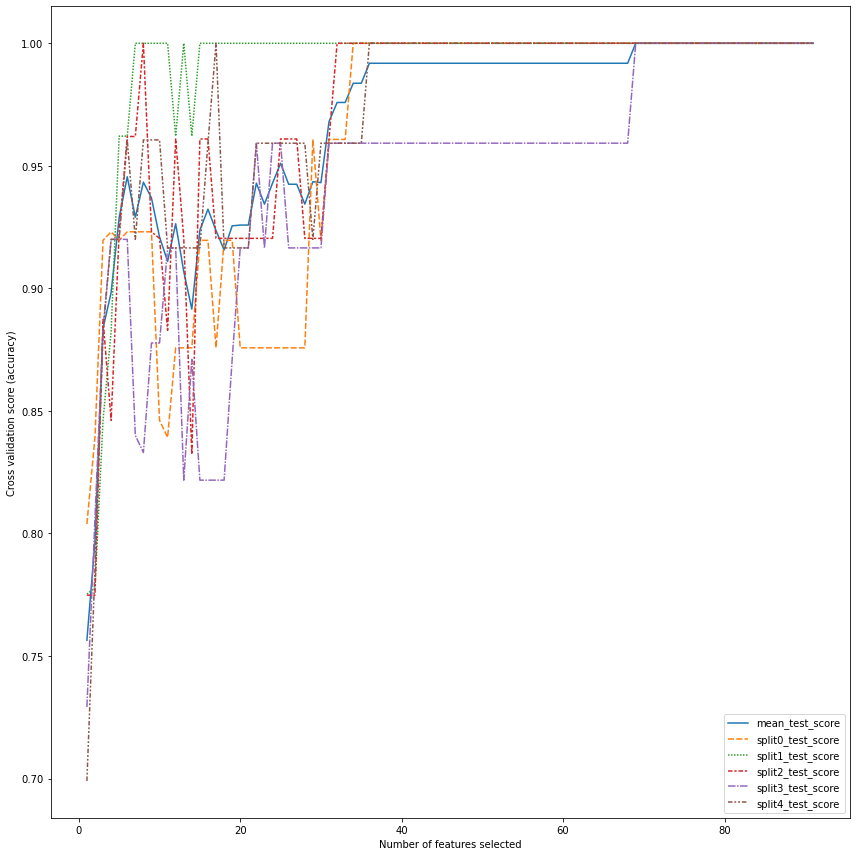

In [14]:
test_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc',SVC(
        class_weight='balanced',
        kernel='linear'
    ))
])
selector = RFECV(
    test_clf,
    scoring='f1_weighted',
    importance_getter='named_steps.svc.coef_',
    cv=StratifiedKFold(random_state=rfecv_rand_seed, shuffle=True)
)
selector.fit(X[ward_feature_names], Y)
rfecv_feature_names = list(selector.get_feature_names_out())

print("Optimal number of features : %d" % selector.n_features_)
print('Features selected:', *rfecv_feature_names)

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(12,12))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
selector_data = pd.DataFrame.from_dict(selector.cv_results_)
selector_data.set_index(np.arange(1,selector.n_features_in_+1), inplace=True)
selector_data.drop(columns='std_test_score', inplace=True)

sns.lineplot(
    data=selector_data
)
plt.tight_layout()
plt.savefig('../figures/RFECV-line-plot.eps')
plt.show()

In [15]:
feature_X_train, feature_X_test, y_train, y_test = train_test_split(
    data[rfecv_feature_names],
    Y,
    stratify=Y,
    random_state=classification_report_rand_seed
)
test_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc',SVC(
        class_weight='balanced',
        kernel='linear',
        probability=True))
])
test_clf.fit(feature_X_train, y_train)
print(classification_report(
    y_test,
    test_clf.predict(feature_X_test)
))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00        10
           E       1.00      1.00      1.00        22

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



In [16]:
test_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc',SVC(
        class_weight='balanced',
        kernel='linear',
        probability=True))
])
cross_validate(
    test_clf,
    X[rfecv_feature_names],
    Y,
    scoring=[
        'balanced_accuracy',
        'roc_auc',
        'f1_weighted'
    ]
)

{'fit_time': array([0.00524378, 0.00478053, 0.00482583, 0.00522757, 0.00522804]),
 'score_time': array([0.00444388, 0.0042243 , 0.00421953, 0.00427198, 0.00428891]),
 'test_balanced_accuracy': array([1., 1., 1., 1., 1.]),
 'test_roc_auc': array([1., 1., 1., 1., 1.]),
 'test_f1_weighted': array([1., 1., 1., 1., 1.])}

In [18]:
test_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc',SVC(
        class_weight='balanced',
        kernel='linear'))
])
test_clf.fit(X[rfecv_feature_names], Y)

coefficents = pd.DataFrame(
    np.abs(test_clf.named_steps.svc.coef_),
    columns=rfecv_feature_names
).T
coefficents.sort_values(0, ascending=False, inplace=True)

# start a cluster using ipcluster start in a terminal before executing this
rc = ipp.Client()
with rc[:].sync_imports():
    import numpy
    from scipy.stats import spearmanr
    from scipy.cluster import hierarchy
    from scipy.spatial.distance import squareform
    from sklearn.svm import LinearSVC,SVC
    from sklearn.preprocessing import StandardScaler,FunctionTransformer
    from sklearn.model_selection import GridSearchCV,StratifiedKFold
    from sklearn.feature_selection import RFECV,SelectFromModel
    from sklearn.pipeline import Pipeline
    from collections import Counter

def drop_collinear_features(X, threshold=0):
    # borrowed directly from scikit learn docs:
    # https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#handling-multicollinear-features
    corr = spearmanr(X).correlation
    corr = (corr + corr.T) / 2
    numpy.fill_diagonal(corr, 1)

    distance_matrix = 1 - numpy.abs(corr)
    dist_linkage = hierarchy.ward(
        squareform(
            numpy.nan_to_num(distance_matrix)
        )
    )
    clustering = hierarchy.fcluster(
        dist_linkage,
        t=threshold,
        criterion='distance')
    mask = numpy.ones(len(X.columns), bool)
    mask[numpy.unique(clustering, return_index=True)[1]] = 0
    return X.assign(**{ c : 0.0 for c in X.columns[mask] })

rand_state = np.random.RandomState(permutation_test_rand_seed)
for v in rc:
    v.push({
        'rand_state' : np.random.RandomState(rand_state.randint(2**30, size=128))
    })

@ipp.require(
    Y=Y,
    X=X,
    coefficents=coefficents,
    drop_collinear_features=drop_collinear_features
)
def task(_):
    # pretty inefficent way to do this but eh
    A_idx = rand_state.choice(Y.index[Y == 'A'].tolist())
    E_idx = rand_state.choice(Y.index[Y == 'E'].tolist())
    y_shuffled = Y.copy()
    y_shuffled.iloc[A_idx] = 'E'
    y_shuffled.iloc[E_idx] = 'A'
    
    clf = Pipeline([
        ('standardize',StandardScaler()),
        ('clf', LinearSVC(
            penalty='l1',
            class_weight='balanced',
            dual=False,
            max_iter=10000
        ))
    ])
    selector = SelectFromModel(
        clf, 
        importance_getter='named_steps.clf.coef_'
    )

    selector.fit(X, y_shuffled)
    l1_feature_names_loc = list(selector.get_feature_names_out())
    
    #test_clf = Pipeline([
    #    ('drop_features', FunctionTransformer(drop_collinear_features)),
    #    ('scaler', StandardScaler()),
    #    ('svc',SVC(
    #        class_weight='balanced',
    #        kernel='linear'
    #    ))
    #])

    #search = GridSearchCV(
    #    test_clf,
    #    { 'drop_features__kw_args' : [
    #        { 'threshold' : v }
    #            for v in list(numpy.arange(0.25,1.75,0.1))[::-1]
    #    ]},
    #    cv=StratifiedKFold(
    #        random_state=rand_state,
    #        shuffle=True
    #    )
    #)
    #with numpy.errstate(divide='ignore', invalid='ignore'):
    #    search.fit(X[l1_feature_names_loc], y_shuffled)

    #ward_feature_names_loc = drop_collinear_features(
    #    X[l1_feature_names_loc],
    #    search.best_params_['drop_features__kw_args']['threshold']).columns

    test_clf = Pipeline([
        ('scaler', StandardScaler()),
        ('svc',SVC(
            class_weight='balanced',
            kernel='linear'
        ))
    ])
    selector = RFECV(
        test_clf,
        min_features_to_select=1,
        scoring='f1_weighted',
        importance_getter='named_steps.svc.coef_',
        cv=StratifiedKFold(
            random_state=rand_state,
            shuffle=True)
    )
    selector.fit(X[l1_feature_names_loc], y_shuffled)
    
    test_clf.fit(X[list(selector.get_feature_names_out())], y_shuffled)
    
    excede_count = Counter()
    for coef in numpy.ravel(numpy.abs(test_clf.named_steps.svc.coef_)):
        excede_count['total'] += 1
        excede_count.update(coefficents.index[numpy.abs(coefficents[0]) < numpy.abs(coef)])
    
    return excede_count,(test_clf.named_steps.svc.coef_.shape[1] > coefficents.shape[1])

iterations = 5000
excede_count = Counter()
coef_count = Counter()

lview = rc.load_balanced_view()
lview.block = True

async_result = lview.map(task, range(iterations), block=False, ordered=False, chunksize=10)
#progress_bar(async_result)
async_result.wait_interactive()

for c,l in async_result:
    excede_count.update(c)
    coef_count[l] += 1

 500/500 tasks finished after 1648 s
done


In [19]:
total = excede_count['total']
df = pd.DataFrame.from_dict(
    excede_count,
    orient='index'
)
df.sort_values(0, inplace=True)
df = ((df/total)*100).round(2)
df[0]['total'] = total
df

,0
POLR1A,1.24
CROCCP2,7.21
PLA2G4C,16.63
PIF1,18.40
TUBB8,21.51
...,...
CALHM1,98.86
WEE2,99.41
BTNL8,99.53
Smc1b,99.71


In [20]:
(1+coef_count[False])/(sum(coef_count.values())+2)

0.00019992003198720512

In [ ]:
# start a cluster using ipcluster start in a terminal before executing this
rc = ipp.Client()
with rc[:].sync_imports():
    import numpy
    import sklearn
    import sklearn.svm
    import sklearn.preprocessing
    import sklearn.model_selection
    import sklearn.pipeline
    import shap
    import contextlib
    import os
    
rand_state = np.random.RandomState(seed=shap_bootstrap_rand_seed)
for v in rc:
    v.push({
        'rand_state' : np.random.RandomState(rand_state.randint(2**30, size=128))
    })

@ipp.require(
    Y=Y,
    X=X[rfecv_feature_names]
)
def task(_):
    try:
        test_clf = sklearn.pipeline.Pipeline([
            ('scaler', sklearn.preprocessing.StandardScaler()),
            ('svc',sklearn.svm.SVC(
                class_weight='balanced',
                kernel='linear',
                probability=True,
                random_state=rand_state
            ))
        ])

        feature_X_train, feature_X_test, y_train, y_test = sklearn.model_selection.train_test_split(
            X,
            Y,
            stratify=Y,
            random_state=rand_state
        )

        test_clf.fit(feature_X_train.values, y_train.values)
        with contextlib.redirect_stderr(open(os.devnull, 'w')):
            explainer = shap.KernelExplainer(
                test_clf.predict_proba,
                feature_X_train
            )
            shap_values = explainer.shap_values(
                feature_X_test,
                link='logit',
                silent=True)

        return numpy.abs(shap_values[1]).mean(axis=0)
    except Exception as ex:
        print('exception', ex)
        return None

iterations = 5000

lview = rc.load_balanced_view()
lview.block = True

async_result = lview.map(task, range(iterations), block=False, ordered=False, chunksize=10)
async_result.wait_interactive()

replicates = [replicate for replicate in async_result]

  14/500 tasks finished after 118928 s

In [ ]:
shap_data = pd.DataFrame(
  np.row_stack(replicates),
  columns=rfecv_feature_names
)

plt.figure(figsize=(12,12))
plt.title('Bootstrapped SHAP importance')
plt.xlabel('Model Impact (mean SHAP value magnitude)')
sns.stripplot(
    data=shap_data,
    orient='h',
    order=list(shap_data.median(axis=0).sort_values(ascending=False).index)
)
plt.savefig('../figures/bootstrap-shap-importance.eps')
plt.show()

In [ ]:
test_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc',SVC(
        class_weight='balanced',
        kernel='linear'))
])
test_clf.fit(X[rfecv_feature_names], Y)
joblib.dump(test_clf, '../data/classifier.joblib')

pval_col_name = 'FDR'

fdr_data = multipletests(
    ttest_ind(
        X[Y == 'E'][rfecv_feature_names],
        X[Y == 'A'][rfecv_feature_names],
        axis=0
    )[1]
)
df = pd.DataFrame(
    {
        test_clf.classes_[1]+'A' : [ 'H' if coef > 0 else 'L' for coef in test_clf.named_steps.svc.coef_[0]],
        test_clf.classes_[0]+'A' : [ 'H' if coef < 0 else 'L' for coef in test_clf.named_steps.svc.coef_[0]],
        'EA means' : X[Y == 'E'][rfecv_feature_names].mean().round(2),
        'AA means' : X[Y == 'A'][rfecv_feature_names].mean().round(2),
         pval_col_name : fdr_data[1].round(3),
        'reject' : fdr_data[0]
    },
    index=rfecv_feature_names
)
df.sort_values(pval_col_name, inplace=True)
ttest_feature_names = df[df[pval_col_name] < 0.05].index
df.replace(0, value='< 0.001', inplace=True)
df

In [ ]:
scaler = StandardScaler()
idx_order = np.argsort(Y)
plt.figure(figsize=(12,12))
sns.heatmap(
    data=scaler.fit_transform(data[ttest_feature_names].iloc[idx_order,:]).T,
    center=0,
    xticklabels=False,
    yticklabels=ttest_feature_names,
    cmap='vlag'
)
vline_pos = list(Y.iloc[idx_order]).index('E')
plt.axvline(vline_pos)
plt.text(vline_pos-4, -0.4, 'AA | EA')

plt.savefig('../figures/expression-heatmap.eps')
plt.tight_layout()

In [ ]:
%watermark \
--python \
--packages pandas,sklearn,scipy,matplotlib,seaborn,shap \
--date --updated